In [17]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow import math
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from utils import load_dataset, train

In [2]:
from tensorflow.config import list_physical_devices

assert len(list_physical_devices('GPU'))

In [3]:
def schedule(epoch, lr) -> float:
    if epoch >= 200 and epoch % 25 == 0:
        lr = lr * math.exp(-0.1)
#         print(f'Epoch {epoch}\tNew LR: {lr}')
    return lr

In [4]:
def train(dataset, model, epochs, verbose=0, validation_freq=1, callbacks=[]) -> Sequential:
    X_train, y_train, X_test, y_test = dataset

    model.compile(optimizer=optimizer, loss='mse')

    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test),
                        validation_freq=validation_freq,
                        verbose=verbose
    )

    passed_epochs = len(history.history['loss'])
    plt.plot(range(passed_epochs), history.history['loss'], label='loss')
    plt.plot(range(validation_freq, passed_epochs + 1, validation_freq),
             history.history['val_loss'],
             label='val loss'
    )
    plt.legend()
    plt.show()

    return model

In [5]:
def plot_roc(y_true, y_score, boundary: int):
    y = np.where(y > boundary, 0, 1)
    pred = np.where(pred > boundary, 0, 1)

    fpr, tpr, thresholds = roc_curve(y, pred)

    plt.title(f'ROC curve with boundary {boundary}')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.plot(tpr, fpr)
    plt.show()
    print(f'Thresholds: {thresholds}')

In [6]:
def auc(y_true, y_score, boundary: int):
    y = np.where(y_true > boundary, 0, 1)
    pred = np.where(y_score > boundary, 0, 1)

    return roc_auc_score(y, pred)

In [14]:
scheduler = LearningRateScheduler(schedule)
es = EarlyStopping(monitor='loss', patience=10, verbose=1)
optimizer = Adam(lr=1e-3)

epochs = 1000
validation_freq = 5

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 4)                 16080     
_________________________________________________________________
dropout_10 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 16,129
Trainable params: 16,129
Non-trainable params: 0
_________________________________________________________________
--------------- Starting model 0 on noise 0 ---------------
Epoch 00390: early stopping


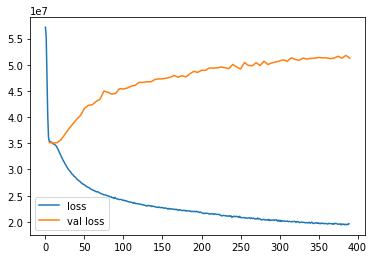

Elapsed time 1110.2425141334534
--------------- Starting model 0 on noise 1 ---------------


KeyboardInterrupt: 

In [18]:
start_time = time.time()
for fname in os.listdir('model_saves/eval_models'):

    lstm = load_model(f'model_saves/eval_models/{fname}')
    lstm.summary()

    for n in [0, 1, 2, 3, 5, 8]:
        print(f'-------------- Starting model {i} on noise {n} --------------')
        X_train, y_train, X_test, y_test = load_dataset(f'm{n}')

        lstm.set_weights(weights[i])  # reset weights
        model = train((X_train, y_train, X_test, y_test), lstm, epochs, 0,
                      validation_freq, [scheduler, es])

        for boundary in [300, 500, 1000, 2500, 5000]:
            # plot_roc(y_test, model.predict(X_test), boundary)
            print(auc(y_test, model.predict(X_test), boundary))

        model.save(f'model_saves/tests/lstm-{i}{n}-model.h5')
        print(f'Elapsed time: {time.time() - start_time}')